In [1]:
import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fit_plane(X):
    """
    Fit a plane to a set of 3d points
    
    Parameters
    ----------
    X : n x 3 array
        points
        
    Returns
    ------
    normal : (3,) vector
        the normal vector of the plane
    c : (3,) vector
        a point on the plane 
    """
    
    # http://math.stackexchange.com/questions/99299/best-fitting-plane-given-a-set-of-points
    # http://math.stackexchange.com/a/3871  
    c = X.mean(axis=0)
    Xc = X - c
    U, _, VT = np.linalg.svd(Xc.T)
    return U[:,-1], c        

def R_align_two_vectors(a, b):
    """
    Find the 
    """
    # http://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d/897677#897677

    v = np.cross(a, b)
    s = np.linalg.norm(v)
    c = np.dot(a, b)
    v_skew = np.array([[0, -v[2], v[1]],
                      [v[2], 0, -v[0]],
                      [-v[1], v[0], 0]])
    R = np.eye(3) + v_skew + np.dot(v_skew, v_skew)*(1-c)/s**2
    return R    


def average_location(centroid_allLandmarks):

    mean_centroid_allLandmarks = {name: np.mean(centroids, axis=0) 
                                  for name, centroids in centroid_allLandmarks.iteritems()}
    
    # Fit a midplane from the midpoints of symmetric landmark centroids
    midpoints = {}
    for name in labels_unsided:

        if name == 'sp5' or name == 'outerContour':
            continue

        names = labelMap_unsidedToSided[name]

        # maybe ignoring singular instances is better
        if len(names) == 2:
            midpoints[name] = .5 * mean_centroid_allLandmarks[names[0]] + .5 * mean_centroid_allLandmarks[names[1]]
    #     else:
    #         midpoints[name] = mean_centroid_allLandmarks[names[0]]

    midplane_normal, midplane_point = fit_plane(np.c_[midpoints.values()])

    print midplane_normal,'@', midplane_point

    R_to_canonical = R_align_two_vectors(midplane_normal , np.r_[0, 0, 1])

    points_midplane_oriented = {name: np.dot(R_to_canonical, p - midplane_point) 
                                for name, p in mean_centroid_allLandmarks.iteritems()}

    canonical_locations = {}

    for name in labels_unsided:

        if name == 'sp5' or name == 'outerContour':
            continue

        names = labelMap_unsidedToSided[name]
        if len(names) == 2:
            x, y, mz = .5 * points_midplane_oriented[names[0]] + .5 * points_midplane_oriented[names[1]]
            canonical_locations[names[0]] = np.r_[x, y, points_midplane_oriented[names[0]][2]-mz]
            canonical_locations[names[1]] = np.r_[x, y, points_midplane_oriented[names[1]][2]-mz]
        else:
            x, y, _ = points_midplane_oriented[name]
            canonical_locations[name] = np.r_[x, y, 0]

    return canonical_locations

In [192]:
recorded_pairs = pickle.load(open('/home/yuncong/csd395/CSHL_volumes_resection/recorded_pairs.pkl', 'r'))

In [193]:
P = np.array([x for pair in recorded_pairs['sameZ'] for x in pair])
midplane_normal, midplane_point = fit_plane(P)

In [194]:
R = R_align_two_vectors(midplane_normal, np.r_[0, 0, 1])

In [ ]:
all_points = np.array([x for which, pairs in recorded_pairs.iteritems() for pair in pairs for x in pair])
centroid = all_points.mean(axis=0)

In [ ]:
pair_diffs = {}
for which, pairs in recorded_pairs.iteritems():
    pair_diffs[which] = np.array([np.array(p)-np.array(q) for p, q in pairs])

In [ ]:
pair_diffs

In [ ]:
m = {}
for which, D in pair_diffs.iteritems():
    U, S, VT = np.linalg.svd(D)
    print S
    m[which] = VT.T[:,-1]
#     print np.dot(D, m[which])

In [ ]:
T = np.vstack([m['sameX'], m['sameY'], m['sameZ']])
print T

In [ ]:
np.linalg.svd(T)

In [18]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


In [205]:
volume = bp.unpack_ndarray_file(volume_dir+'/MD589/MD589_thumbnailVolume.bp')

In [206]:
volume.shape

(367, 499, 604)

In [177]:
volume1_ydim = 500
volume1_xdim = 600
volume1_zdim = 700

In [178]:
# ys, xs, zs = np.meshgrid(np.arange(volume.shape[0]), 
#            np.arange(volume.shape[1]),
#            np.arange(volume.shape[2]))

ys, xs, zs = np.meshgrid(np.arange(volume1_ydim), 
           np.arange(volume1_xdim),
           np.arange(volume1_zdim), indexing='ij')

ys = ys.flatten()
xs = xs.flatten()
zs = zs.flatten()

In [179]:
volume1_pts = np.c_[xs,ys,zs]

In [24]:
hxy = 0
hyx = 0
hzx = 0
hzy = 0

# hyz = .01 # how much y is dependent on z, coronal up/down shear, positive for left up, right down
# hxz = 0.
# Sh = np.array([[1, hxy, hxz],[hyx, 1, hyz],[hzx, hzy, 1]])

In [244]:
ps_sameY = np.array([p for p, q in recorded_pairs['sameY']])
qs_sameY = np.array([q for p, q in recorded_pairs['sameY']])
print np.linalg.norm(ps_sameY[:, 1] - qs_sameY[:, 1])

ps_sameX = np.array([p for p, q in recorded_pairs['sameX']])
qs_sameX = np.array([q for p, q in recorded_pairs['sameX']])
print np.linalg.norm(ps_sameX[:, 0] - qs_sameX[:, 0])

ps_sameY_afterR = (np.dot(R, (ps_sameY - midplane_point).T) + midplane_point[:,None]).T
qs_sameY_afterR = (np.dot(R, (qs_sameY - midplane_point).T) + midplane_point[:,None]).T
print np.linalg.norm(ps_sameY_afterR[:, 1] - qs_sameY_afterR[:, 1])

ps_sameX_afterR = (np.dot(R, (ps_sameX - midplane_point).T) + midplane_point[:,None]).T
qs_sameX_afterR = (np.dot(R, (qs_sameX - midplane_point).T) + midplane_point[:,None]).T
print np.linalg.norm(ps_sameX_afterR[:, 0] - qs_sameX_afterR[:, 0])

def f(params):
    hyz_, hxz_ = params
#     hyz_ = params[0]
#     hxz_ = 0

    Sh = np.array([[1, hxy, hxz_],[hyx, 1, hyz_],[hzx, hzy, 1]])
    
    ps_after = (np.dot(np.dot(Sh, R), (ps_sameY - midplane_point).T) + midplane_point[:,None]).T
    qs_after = (np.dot(np.dot(Sh, R), (qs_sameY - midplane_point).T) + midplane_point[:,None]).T
#     diff_y = np.sum(np.abs(ps_after[:, 1] - qs_after[:, 1]))
    diff_y = np.linalg.norm(ps_after[:, 1] - qs_after[:, 1])
    
#     return diff_y
    
    ps_after = (np.dot(np.dot(Sh, R), (ps_sameX - midplane_point).T) + midplane_point[:,None]).T
    qs_after = (np.dot(np.dot(Sh, R), (qs_sameX - midplane_point).T) + midplane_point[:,None]).T
#     diff_x = np.sum(np.abs(ps_after[:, 1] - qs_after[:, 1]))
    diff_x = np.linalg.norm(ps_after[:, 0] - qs_after[:, 0])
    
#     return diff_x

    return diff_x + diff_y

23.2808934536
12.0415945788
45.0376632239
23.709294886


In [245]:
import numdifftools as nd
# https://media.readthedocs.org/pdf/numdifftools/latest/numdifftools.pdf

In [246]:
gr = nd.Gradient(f, step=[1., 1.])

r = np.array([0.001, 0.001])
param = np.array([0., 0.])
converged = False
for _ in range(1000):
    g = gr(param)
#     print np.linalg.norm(g)
    param_new = param - r * g
    print param, f(param)
    if np.linalg.norm(f(param_new)-f(param)) < 1e-4:
        converged = True
        break
    param = param_new

print converged
print f(param)
print param

[ 0.  0.] 68.7469581099
[-0.04326568  0.02090141] 37.5749237185
[-0.06225011  0.0306791 ] 27.0819276657
[-0.07058022  0.03525312] 24.3828470592
[-0.07423535  0.03739284] 23.8025421276
[-0.07583917  0.03839381] 23.6847169056
[-0.07654291  0.03886206] 23.6610352511
[-0.0768517   0.03908111] 23.6562712765
[-0.07698719  0.03918358] 23.6553098381
[-0.07704664  0.03923151] 23.6551150741
True
23.6551150741
[-0.07704664  0.03923151]


In [247]:
hyz, hxz = param
# hyz, hxz = (0, 0)
Sh = np.array([[1, hxy, hxz],[hyx, 1, hyz],[hzx, hzy, 1]])

In [250]:
corresponding_volume_pts = (np.dot(np.linalg.inv(np.dot(Sh, R)), (volume1_pts - midplane_point).T) + midplane_point[:,None]).T.astype(np.int)
# corresponding_volume_pts = (np.dot(np.linalg.inv(R), (volume1_pts - midplane_point).T) + midplane_point[:,None]).T.astype(np.int)
# corresponding_volume_pts = (np.dot(np.linalg.inv(T), (volume1_pts - centroid).T) + centroid[:,None]).T.astype(np.int)

In [251]:
m = (corresponding_volume_pts[:,0] >= 0) & ((corresponding_volume_pts[:,1] >= 0)) & (corresponding_volume_pts[:,2] > 0) &\
(corresponding_volume_pts[:,0] < volume.shape[1]) & (corresponding_volume_pts[:,1] < volume.shape[0]) & (corresponding_volume_pts[:,2] < volume.shape[2]) \
# & (volume1_pts[:,0] > 10) & (volume1_pts[:,0] < 100) 

In [252]:
import time
t = time.time()

valid_volume1_pts = volume1_pts[m]
valid_volume_pts = corresponding_volume_pts[m]

volume1 = np.zeros((volume1_ydim, volume1_xdim, volume1_zdim), np.uint8)
# for (x,y,z), (x0,y0,z0) in zip(valid_volume1_pts, valid_volume_pts):
#     volume1[y,x,z] = volume[y0,x0,z0]
volume1[valid_volume1_pts[:,1],valid_volume1_pts[:,0],valid_volume1_pts[:,2]] = \
volume[valid_volume_pts[:,1],valid_volume_pts[:,0],valid_volume_pts[:,2]]

print time.time() - t

# volume1 = np.zeros((volume1_ydim, volume1_xdim, volume1_zdim), np.uint8)
# volume1[volume1_pts[m,1],volume1_pts[m,0],volume1_pts[m,2]] = \
# volume[corresponding_volume_pts[m,1],corresponding_volume_pts[m,0],corresponding_volume_pts[m,2]]

11.5362679958


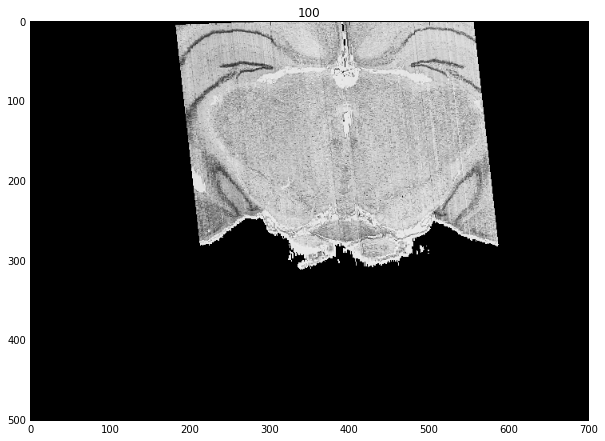

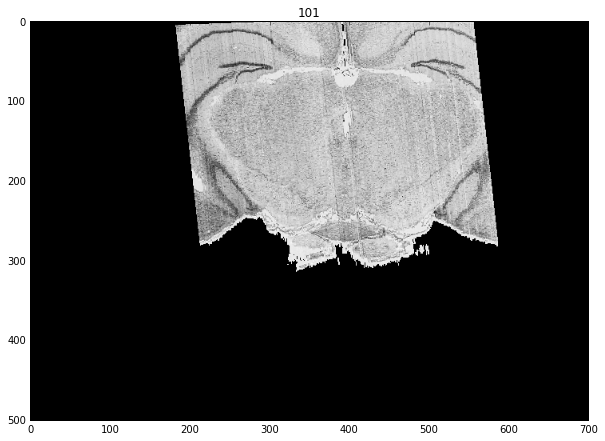

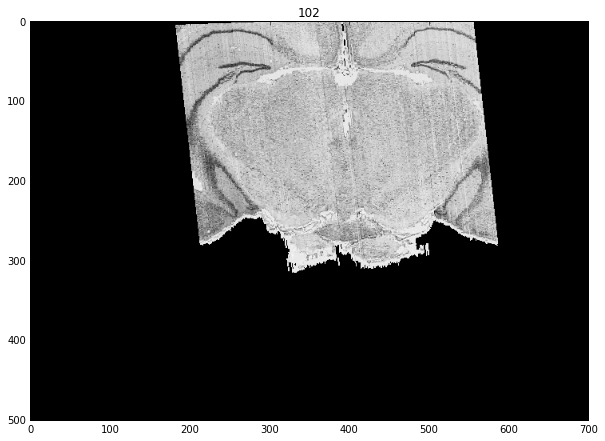

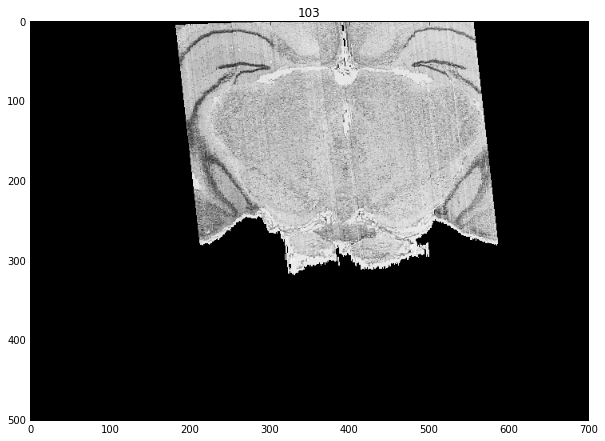

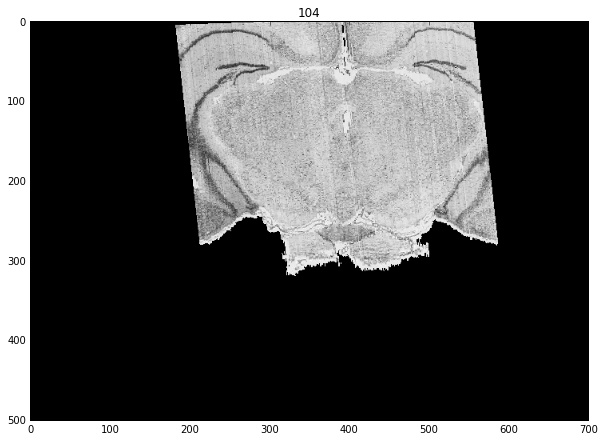

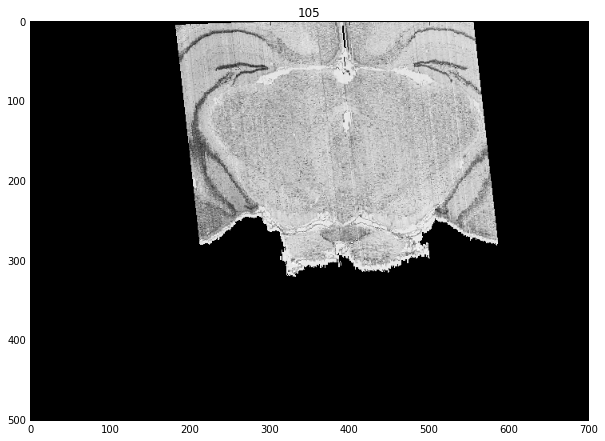

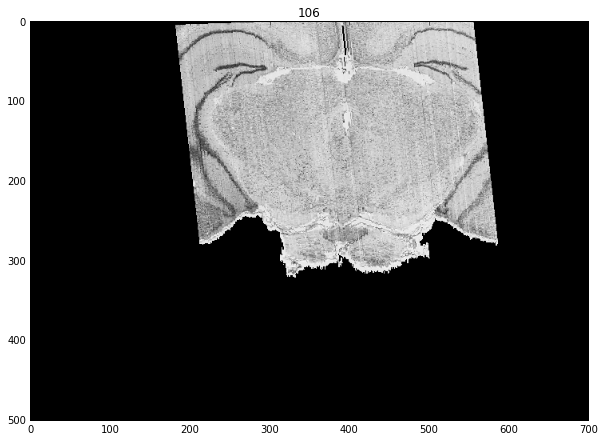

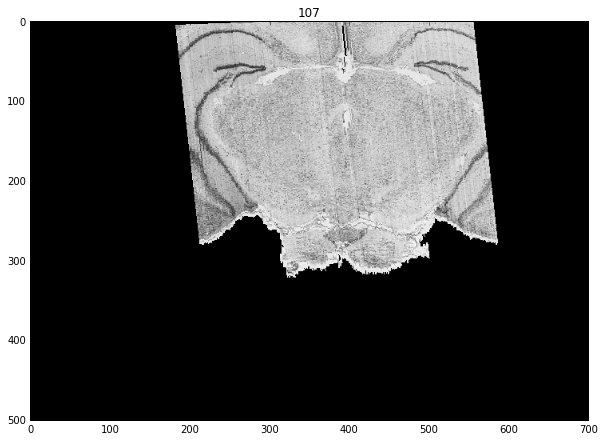

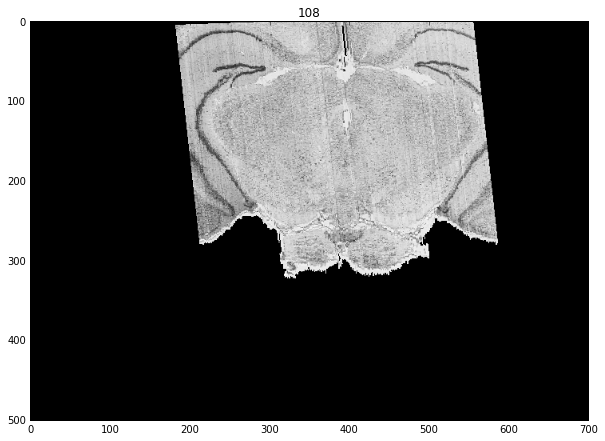

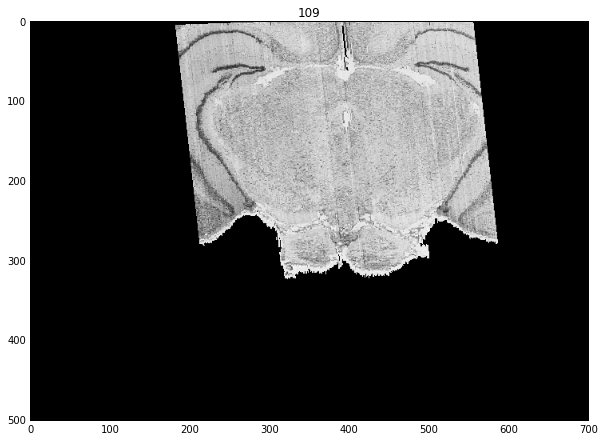

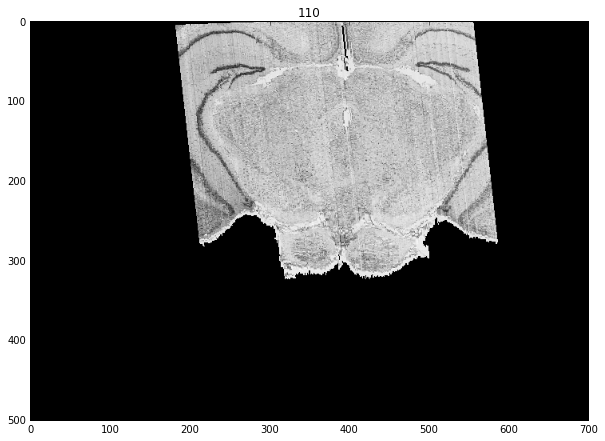

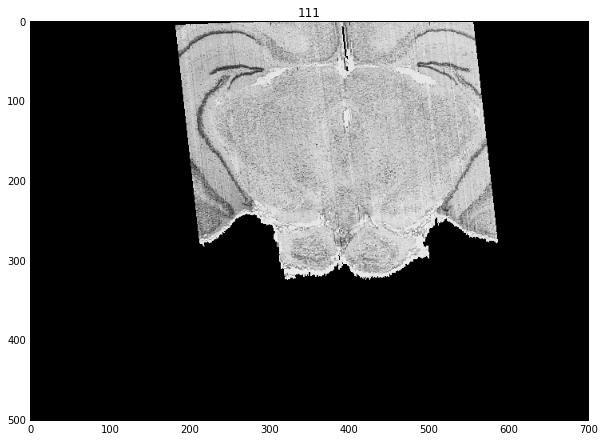

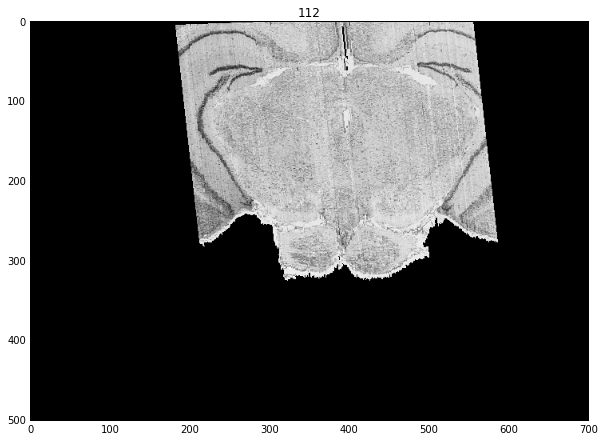

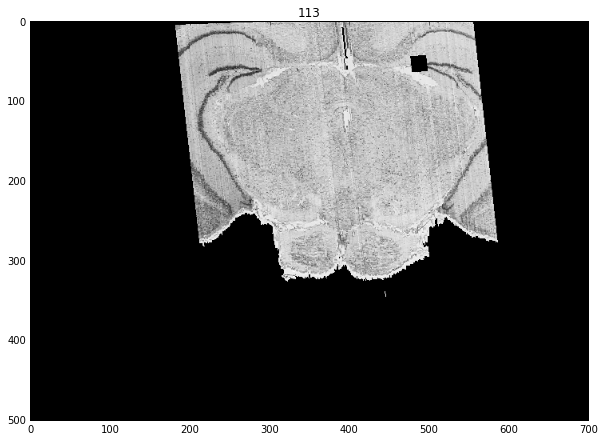

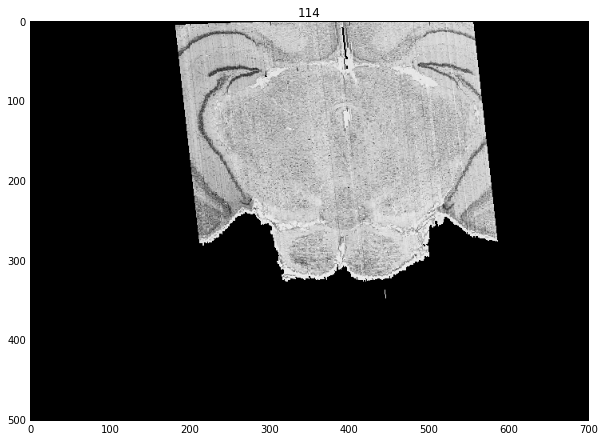

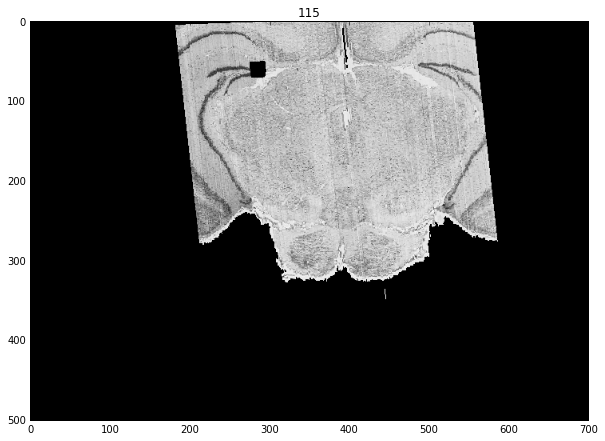

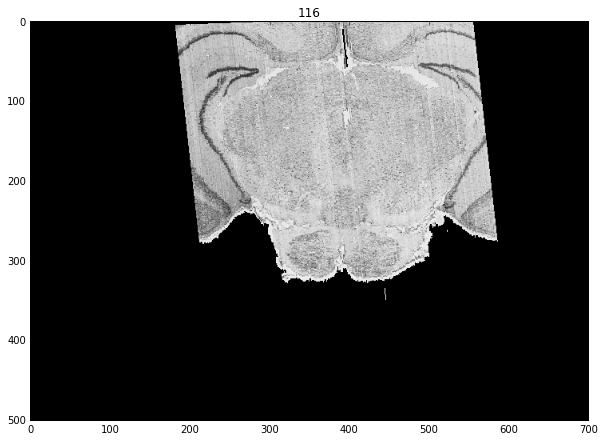

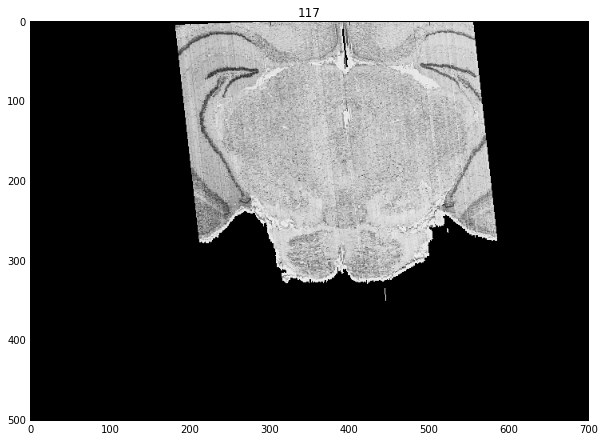

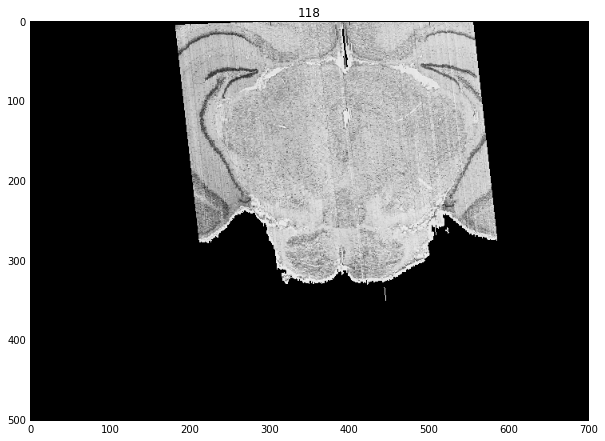

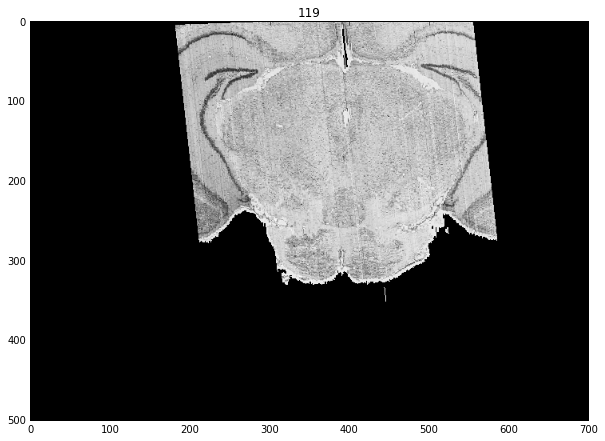

In [253]:
# for y in range(volume1.shape[0]):
# for x in range(0, volume1.shape[1]):
for x in range(100, 120):
    plt.figure(figsize=(10,10));
    plt.title('%d' % x);
    plt.imshow(volume1[:,x,::-1], cmap=plt.cm.gray);
    plt.show();

In [254]:
resection_dir = '/home/yuncong/csd395/CSHL_volumes_resection'

In [255]:
stack = 'MD589'

In [256]:
for y in range(volume1.shape[0]):
    create_if_not_exists(os.path.join(resection_dir, 'rectified_horizontal'))
    imsave(os.path.join(resection_dir, 'rectified_horizontal', '%s_thumbnailVolume_horizontal_%03d.jpg'%(stack, y)), volume1[y,:,::-1].T)

In [257]:
for x in range(volume1.shape[1]):
    create_if_not_exists(os.path.join(resection_dir, 'rectified_coronal'))
    imsave(os.path.join(resection_dir, 'rectified_coronal', '%s_thumbnailVolume_coronal_%03d.jpg'%(stack, x)), volume1[:,x,::-1])

In [258]:
for z in range(volume1.shape[2]):
    create_if_not_exists(os.path.join(resection_dir, 'rectified_sagittal'))
    imsave(os.path.join(resection_dir, 'rectified_sagittal', '%s_thumbnailVolume_sagittal_%03d.jpg'%(stack, z)), volume1[:,:,z])

In [ ]:
# WRONG !!
# angles between three axes
# print np.rad2deg(np.arccos(np.dot(T[0], T[1])))
# print np.rad2deg(np.arccos(np.dot(T[1], T[2])))
# print np.rad2deg(np.arccos(np.dot(T[0], T[2])))

In [ ]:
# angles between three axes
print np.rad2deg(np.arccos(np.dot(T[:,0], T[:,1])))
print np.rad2deg(np.arccos(np.dot(T[:,1], T[:,2])))
print np.rad2deg(np.arccos(np.dot(T[:,0], T[:,2])))

In [ ]:
recorded_pairs_after = {which: [(np.dot(T, (p-centroid).T).T + centroid,
                       np.dot(T, (q-centroid).T).T + centroid) for p,q in pairs]
                       for which, pairs in recorded_pairs.iteritems()}

In [ ]:
s = 0
for which, pairs in recorded_pairs.iteritems():    
    if which == 'sameX':
        diff_x = np.sqrt(np.sum([(p[0]-q[0])**2 for p,q in pairs]))
        s += diff_x
    elif which == 'sameY':
        diff_y = np.sqrt(np.sum([(p[1]-q[1])**2 for p,q in pairs]))
        s += diff_y
    elif which == 'sameZ':
        diff_z = np.sqrt(np.sum([(p[2]-q[2])**2 for p,q in pairs]))
        s += diff_z

print diff_x, diff_y, diff_z, s

In [ ]:
s = 0
for which, pairs in recorded_pairs_after.iteritems():    
    if which == 'sameX':
        diff_x = np.sqrt(np.sum([(p[0]-q[0])**2 for p,q in pairs]))
        s += diff_x
    elif which == 'sameY':
        diff_y = np.sqrt(np.sum([(p[1]-q[1])**2 for p,q in pairs]))
        s += diff_y
    elif which == 'sameZ':
        diff_z = np.sqrt(np.sum([(p[2]-q[2])**2 for p,q in pairs]))
        s += diff_z

print diff_x, diff_y, diff_z, s

In [ ]:
recorded_pairs

In [ ]:
recorded_pairs_after

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

In [ ]:
# https://plot.ly/python/3d-scatter-plots/
# https://plot.ly/python/3d-camera-controls/

data = []
for p1, p2 in recorded_pairs_after['sameY']:

    trace = go.Scatter3d(
        x=[p1[0], p2[0]],
        y=[p1[1], p2[1]],
        z=[p1[2], p2[2]],
        mode='markers',
        marker=dict(
            color='rgb(%s)'%(','.join(map(str, np.random.randint(0,255,3)))),
            size=12,
            symbol='circle',
            line=dict(
                color='rgb(204, 204, 204)',
                width=1
            ),
            opacity=0.9
        )
    )
    
    data += [trace]
    
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
        camera=dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
    )
        )
    )

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='simple-3d-scatter')

In [ ]:
plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs['sameX']:
    plt.scatter([p1[0],p2[0]], [p1[1],p2[1]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs['sameX']:
    plt.scatter([p1[0],p2[0]], [p1[2],p2[2]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs['sameY']:
    plt.scatter([p1[1],p2[1]], [p1[0],p2[0]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs['sameY']:
    plt.scatter([p1[1],p2[1]], [p1[2],p2[2]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs['sameZ']:
    plt.scatter([p1[2],p2[2]], [p1[1],p2[1]], c=np.random.random(3), s=100);
    
plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs['sameZ']:
    plt.scatter([p1[2],p2[2]], [p1[0],p2[0]], c=np.random.random(3), s=100);

In [ ]:
plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs_after['sameX']:
    plt.scatter([p1[0],p2[0]], [p1[1],p2[1]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs_after['sameX']:
    plt.scatter([p1[0],p2[0]], [p1[2],p2[2]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs_after['sameY']:
    plt.scatter([p1[1],p2[1]], [p1[0],p2[0]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs_after['sameY']:
    plt.scatter([p1[1],p2[1]], [p1[2],p2[2]], c=np.random.random(3), s=100);

plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs_after['sameZ']:
    plt.scatter([p1[2],p2[2]], [p1[1],p2[1]], c=np.random.random(3), s=100);
    
plt.figure(figsize=(10,10));
for p1, p2 in recorded_pairs_after['sameZ']:
    plt.scatter([p1[2],p2[2]], [p1[0],p2[0]], c=np.random.random(3), s=100);


In [ ]:
T

In [ ]:
from sympy import symbols, Matrix, sin, cos
# http://docs.sympy.org/latest/tutorial/matrices.html

thx, thy, thz, hxy, hxz, hyx, hyz, hzx, hzy = symbols('thx thy thz hxy hxz hyx hyz hzx hzy')

Rthx = Matrix([[1,0,0,0],[0, cos(thx), -sin(thx), 0],[0,sin(thx),cos(thx),0],[0,0,0,1]])
Rthy = Matrix([[cos(thy),0,sin(thy),0],[0, 1, 0, 0],[-sin(thy),0,cos(thy),0],[0,0,0,1]])
Rthz = Matrix([[cos(thz),-sin(thz),0,0],[sin(thz), cos(thz), 0, 0],[0,0,1,0],[0,0,0,1]])
Sh = Matrix([[1, hxy, hxz, 0],[hyx,1,hyz,0],[hzx,hzy,1,0],[0,0,0,1]])

T = Sh*Rthx*Rthy*Rthz
T[0,:]